# EXOD detector

## Writing to fits file

Importing packages

In [1]:
import sys
import os
import time
from functools import partial
import subprocess

# Third-party imports
from math import *
from multiprocessing import Pool
from astropy.io import fits
from astropy.table import Table
from astropy import wcs
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
import argparse

import scipy
import scipy.ndimage as nd
import matplotlib
from matplotlib import colors, image, transforms
import matplotlib.pyplot as plt
from pylab import figure, cm
from matplotlib.colors import LogNorm
from astropy import wcs

# Internal imports
from fits_extractor import *
from variability_utils import *
import file_names as FileNames
from file_utils import *

Arguments

In [2]:
path = '/home/ines/Documents/projects/EXOD/data/one_observation/0203542001/'
evts = path + 'PN_clean.fits'
gti  = path + 'PN_gti.fits'
out  = path + '8_100_1.0_3'
obs  = '0203542001'
bs   = 3
dl   = 8
tw   = 100
gtr  = 1.0
mta  = 12
ol   = path + 'log.txt'

Preliminaries

In [3]:
log_f, var_f, var_per_tw_f, detected_var_areas_f, tws_f, detected_var_sources_f = open_files(out)
#output_log = open(ol, 'a')
data = extraction_photons(evts)
header, dmin, dmax = extraction_info(evts)

gti_list = extraction_deleted_periods(gti)

time_windows = []
t0_observation = min([evt['TIME'] for ccd in data for evt in ccd])
tf_observation = max([evt['TIME'] for ccd in data for evt in ccd])

## Computing variability

In [4]:
v_matrix = [] 
var_calc_partial = partial(variability_computation, gti_list, tw, gtr, t0_observation, tf_observation)
with Pool(mta) as p:
        v_matrix = p.map(var_calc_partial, data)

#print(v_matrix)

In [5]:
data_v = ccd_config(v_matrix)

## Source detection

In [6]:
median = np.median([v_matrix[ccd][i][j] for ccd in range(12) for i in range(len(v_matrix[ccd])) for j in range(len(v_matrix[ccd][i]))])
if median < 0.75 :
    median = 0.75

variable_areas = []
variable_areas_detection_partial = partial(variable_areas_detection, median, bs, dl)
with Pool(mta) as p:
    variable_areas = p.map(variable_areas_detection_partial, v_matrix)

In [7]:
%reload_ext autoreload
sources = variable_sources_position(variable_areas, obs, path, out)
sources.show_in_notebook()

idx,ID,CCDNR,RAWX,RAWY,RAWR,X,Y,SKYR,RA,DEC,R
0,1,1,31.59,187.93,3.32,29287.94,23690.22,212.48,63.4775,28.1929,10.624


## WCS transformation

In [8]:
data = fits.getdata(evts)
w = wcs.WCS(header)
#header  = header[0].header

w.wcs.crpix = [header['REFXCRPX'], header['REFYCRPX']]
w.wcs.cdelt = [header['REFXCDLT'], header['REFYCDLT']]
w.wcs.crval = [header['REFXCRVL'], header['REFYCRVL']]
w.wcs.ctype = [header['REFXCTYP'], header['REFYCTYP']]
w.wcs.cunit = [header['REFXCUNI'], header['REFYCUNI']]
angle = header['PA_PNT']       # Degrees

# Image limit
dlim = [header['REFXLMIN'], header['REFXLMAX'], header['REFYLMIN'], header['REFYLMAX']]

# Limite maximale de l'échelle des couleurs pour la normalisation par logarithme
#maximum_value = max([max(tmp) for tmp in data])
maximum_value = 10   


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


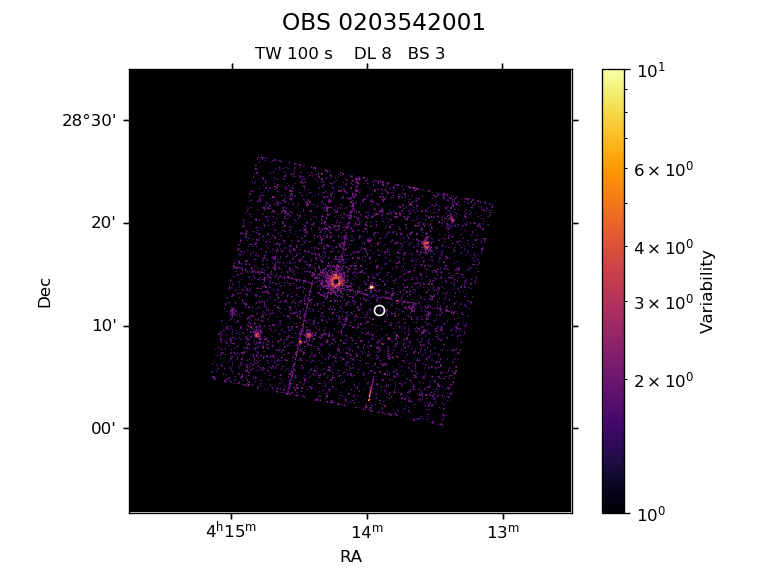

In [9]:
# Transformations
# pivot=[230,145]
# padX = [np.shape(data_v)[1] - pivot[0], pivot[0]]
# padY = [np.shape(data_v)[0] - pivot[1], pivot[1]]
#imgP = np.pad(data_v, [padY, padX], 'constant')
padX = (int((648-len(data_v))/2),)
padY = (int((648-len(data_v[0]))/2),)
imgR = np.flipud(nd.rotate(data_v, angle, reshape = True))
imgT = np.pad(imgR, (padX, padY), 'constant', constant_values=0)

# Plotting the variability data
%matplotlib notebook
plt.subplot(111, projection=w)

im = plt.imshow(imgT, cmap=cm.inferno, norm=LogNorm(vmin=1.0, vmax=maximum_value), extent=dlim, origin='lower')

cbar = plt.colorbar(im)
ax = plt.gca()
ax.set_facecolor('k')
plt.suptitle('OBS {0}'.format(obs), fontsize=14)
plt.title("TW {0} s    DL {1}   BS {2}".format(tw, dl, bs), fontsize=10)
plt.xlabel('RA', fontsize=10)
plt.ylabel('Dec', fontsize=10)
cbar.ax.set_ylabel('Variability', fontsize=10)

# Plotting variable sources
if len(sources) != 0 :
    # Position of the sources
    plt.plot(sources['X'], sources['Y'], 'wo', alpha = 1, fillstyle='none')

In [9]:
%%bash
path=/home/ines/Documents/projects/EXOD/data/one_observation/0203542001
ds9 $path/PN_image.fits -scale log -cmap bb -mode region -regionfile $path/8_100_1.0_3/ds9_variable_sources.reg &

## Writing to file

In [51]:
# Creating table
head_var_f = header
head_var_f.append(card=('CREATOR', 'InesPM', '[s] EXOD Time window'))
head_var_f.append(card=('DATE', time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime()), '[s] EXOD Time window'))
head_var_f.append(card=('TW', tw, '[s] EXOD Time window'))
head_var_f.append(card=('GTR', gtr, 'EXOD Good time ratio'))
head_var_f.append(card=('DL', dl, 'EXOD Detection level'))
head_var_f.append(card=('BS', bs, '[pix] EXOD Box size'))

data_var_f = Table(names=('VARIABILITY', 'RAWX', 'RAWY', 'CCDNR'), dtype=('f8', 'i2', 'i2', 'i2'))


# Writing to file
hdul_var_f = fits.ImageHDU(data=data_v, header=head_var_f)
hdul_var_f.writeto(var_f, overwrite=True)


# Test
for ccd in range(12) :
    data_var_f = Table(names=('VARIABILITY', 'RAWX', 'RAWY', 'CCDNR'), dtype=('f8', 'i2', 'i2', 'i2'))
    test='/home/ines/Documents/projects/EXOD/data/one_observation/0203542001/8_100_1.0_3/ccd{}.fits'.format(ccd+1)
    for i in range(64):
        for j in range(200):
            #var_f.write(str(v_matrix[ccd][i][j]) + '\n')
            data_var_f.add_row([v_matrix[ccd][i][j], i+1, j+1, ccd+1])
            
    fits.writeto(test, data_var_f, header=head_var_f, overwrite=True)

# ds9 evts -bin factor 64 -scale asinh -cmap bb -mode region -regionfile detected_var_sources_f &
# global color=lightgreen
# j2000
# circle(17:46:10.8,-29:00:21,15")